# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Help The Frontier!

Now we will use an LLM to summarize the situation and get another frontier model to assess it


In [13]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic




In [14]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [15]:
# We will use Ollama locally for some models so we will need requests
import requests

In [16]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['OPENROUTER_API_KEY'] = os.getenv('OPENROUTER_API_KEY', 'your-key-if-not-using-env')
os.environ['HYPERBOLIC_API_KEY'] = os.getenv('HYPERBOLIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [17]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [18]:
openai = OpenAI()
claude = Anthropic()

In [19]:
%matplotlib inline

In [20]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [21]:
from datetime import datetime, timedelta

TIMEZONE = datetime.now().astimezone().tzinfo
SYSTEM_PROMPT = f"The timezone here is {str(TIMEZONE)}. "
SYSTEM_PROMPT += """Your task is to analyze log entries from home sensors from a home occupied by an elderly person by grouping them into 6-hour intervals and converting each grouping into a clear, human-readable scenario. For each 6-hour interval, generate a neutral narrative that describes what occurred during that period. Important: The narrative (under "situation_description") must describe the events without any judgment about whether they are normal or anomalous. The determination of "normal" or "anomalous" should be provided solely in the separate "result" field when you are highly confident.

For each 6-hour grouping, ensure the output includes:

situation_description: A concise, neutral summary (4-5 sentences) of the events that took place during the hour. This description should detail the observed movement patterns and sensor events without implying any evaluation.
result: A field that is either "normal" or "anomalous" based strictly on the log data. Do not embed this judgment in the narrative.
start_timestamp and end_timestamp: The exact timestamps from the logs that mark the beginning and end of the 6-hour interval.
details: A list of the raw log entries that occurred during the interval. Each log entry should include the original details (e.g., {"timestamp": 1737900000, "room": "pillbox", "nodeId": 1, "onOff": true}) and be escaped appropriately for JSON formatting.

Important rules:

Do not include any evaluative or judgmental language in the "situation_description." The narrative should allow a human or another LLM to independently assess whether the events are typical for an elderly person in the house.
When describing movements and events, you should mention human readable times of these movements and events but ensure that times used are consistent with the provided start and end timestamps.
When making a determination on whether this situation is normal or anomalous for an elderly person ensure that you consider the times of the day that would be normal for these types of movements and events for an elderly person.
Ensure that any time mentioned in the situation description directly corresponds to the start or end timestamps (and any other provided timestamps), without introducing new or inconsistent values.
Process and return only one 6-hour interval grouping per response.
When determined whether this situation's result is normal or anomalous you should consider times of events such as very late night time and early morning hours being unusual for elderly people.

The output format must strictly adhere to the following JSON structure:
{
"situations": [
{
  "situation_description": "Neutral narrative describing the events that occurred.",
  "result": "normal | anomalous",
  "start_timestamp": "exact log entry timestamp marking the start",
  "end_timestamp": "exact log entry timestamp marking the end",
  "details": "list of log entries that occurred in the interval"
}
]
}

"""

USER_PROMPT_PREFIX = """Analyze the following 6-hour block of log entries and create a neutral, human-readable scenario description of the events observed. 
Your description should summarize the recorded movement patterns in 4-5 clear sentences without including any evaluative language regarding whether the movement is 
typical or atypical. 
Here are the log entries:

"""

USER_PROMPT_SUFFIX = "\n\nStrictly respond in valid JSON format, and only JSON and include exactly 1 situation, no more."



In [22]:
# Lets make a function that adds the event time to make it easier for the LLM to assess
def add_event_time(item):
    # The LLM appear to get confused with timestamped data so lets add a human readable time

    details = json.loads(item.details)
    # Iterate over each event in the details list
    for event in details:
        ts = event["timestamp"]
        # Convert timestamp to a datetime object in local timezone
        dt = datetime.fromtimestamp(ts, tz=TIMEZONE)
        # Format datetime to a human-readable string (e.g., "Sun Jan 26 2025 20:00:00")
        event["datetime"] = dt.strftime("%a %b %d %Y %H:%M:%S")

    item.details = json.dumps(details)
    return item

In [23]:
item = add_event_time(train[0])
item.details

'[{"timestamp": 1804279200, "datetime": "Fri Mar 05 2027 20:40:00", "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}}, {"timestamp": 1804279800, "datetime": "Fri Mar 05 2027 20:50:00", "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 0}}}, {"timestamp": 1804279800, "datetime": "Fri Mar 05 2027 20:50:00", "room": "bathroom", "nodeId": 3, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}}, {"timestamp": 1804280400, "datetime": "Fri Mar 05 2027 21:00:00", "room": "bathroom", "nodeId": 3, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 0}}}, {"timestamp": 1804280400, "datetime": "Fri Mar 05 2027 21:00:00", "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}}, {"timestamp": 1804282500, "datetime": "Fri Mar 05 2027 21:35:00", "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [25]:
# First let's work on a good prompt for a Frontier model
# When we train our own models, we'll need to make the problem as easy as possible, 
# Therefore we will translate the timestamped to a human readable eventtime
# but a Frontier model needs no such simplification.


def messages_for(item):
    system_message = "You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation"
    add_event_time(item)
    user_prompt = item.test_prompt().replace("\n\nResult is ","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Result is "}
    ]

In [26]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You look for normal and anomalous situations in smart home sensor data in an elderly persons home. Reply only with the word normal or anomalous, no explanation'},
 {'role': 'user',
  'content': 'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1709344800, "room": "bedroom", "nodeId": 2, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 02:00:00"}, {"timestamp": 1709345700, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 02:15:00"}, {"timestamp": 1709349300, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 03:15:00"}, {"timestamp": 1709352900, "room": "bedroom", "nodeId": 2, "endpointId": 2, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1900}}, "datetime": "Sat Mar 02 2024 0

In [27]:
# A utility function to extract the result from a string

def get_result(text):
    # Match "normal" or "anomalous" anywhere in the text
    match = re.search(r"\b(normal|anomalous)\b", text, re.IGNORECASE)
    return match.group(1).lower() if match else None

In [28]:
get_result("The result is anomalous because blah blah")

'anomalous'

In [29]:
get_result("anomalous")

'anomalous'

In [30]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

In [31]:
test[0].result

'anomalous'

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709413200, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740553200, "datetime": "...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709247600, "room": "livi...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709294400, "room": "livi...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741086000, "room": "bath...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740560400, "datetime": "...
9: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1741269600, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741262400, "datetime": "...
11: Guess: normal

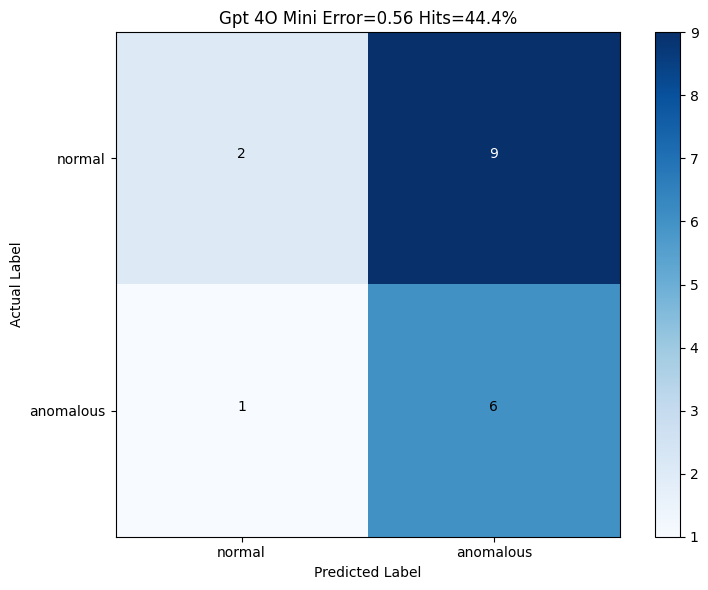

In [32]:
Tester.test(gpt_4o_mini, test)

In [33]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_result(reply)

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1709344800, "room": "bedr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738072800, "room": "livi...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709413200, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1740553200, "datetime": "...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709247600, "room": "livi...
6: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1709294400, "room": "livi...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741086000, "room": "bath...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1740560400, "datetime": "...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1741269600, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741262400, "datetime": "...
11: Guess: normal Truth: norm

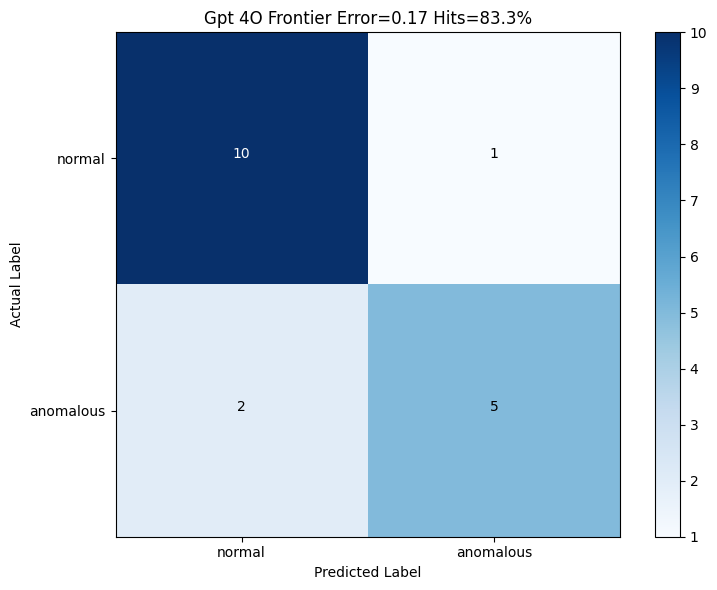

In [34]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [19]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_result(reply)

In [20]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

#Tester.test(claude_3_point_5_sonnet, test)

# We will try a Local Model

In [19]:
# There's actually an alternative approach that some people might prefer
# You can use the OpenAI client python library to call Ollama:

from openai import OpenAI
ollama_via_openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

# This may take a few minutes to run! You should then see a fascinating "thinking" trace inside <think> tags, followed by some decent definitions

response = ollama_via_openai.chat.completions.create(
    model="deepseek-r1:1.5b",
    messages=[{"role": "user", "content": "Please give definitions of some core concepts behind LLMs: a neural network, attention and the transformer"}]
)

print(response.choices[0].message.content)


<think>
Okay, so I need to understand what neural networks are, because that seems related but different from the term "LLMs." Maybe they share some underlying concepts? I should start by breaking down each part. Let's see... For a neural network, I think it has layers of nodes connected together. That must be more like a data model, but how does that connect to LLMs?

The user mentioned attention and transformers are core concepts related to LLMs. The document earlier listed them as being closely tied because transformers are built using recurrent processing units, and attention seems to involve looking at parts of the input in different times. So maybe I should explain these two first.

Then each gets expanded into their own sections on LLMs. First, for neural networks: what makes deep learning models suitable for NLP? That probably includes something like representational power—how good they are at capturing patterns in data—and computational efficiency, which is about how fast and 

In [22]:
# Use Ollama API to query the local `deepseek` model
def deepseek(item):
    response = ollama_via_openai.chat.completions.create(
        model="deepseek-r1:1.5b",
        messages=messages_for(item),
        seed=42
    )
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)
    




1: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738180860, "room": "hall...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738180860, "room": "hall...
3: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1737988800, "room": "livi...


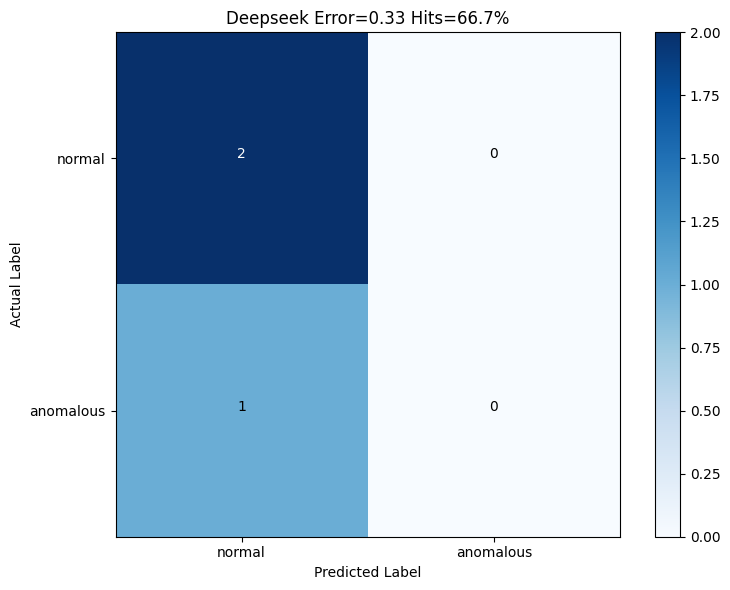

In [24]:
# The function for local install of deepseek
# This takes a long time and could hammer your machine
# You can skip this and look at my results instead

Tester.test(deepseek, test)

# We will try the Emerging models using Openrouter (API provider)



## Lets try Deepskeep with Openrouter!

And now - we put the Deepseek Models to the test.

In [23]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.environ['OPENROUTER_API_KEY'],
)


In [26]:
completion = client.chat.completions.create(
  model="deepseek/deepseek-r1:free",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
print(completion)

ChatCompletion(id='gen-1739957810-PVdskPlNB5DPJfZ829UR', choices=[Choice(finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='token_id:33001', bytes=[79, 107, 97, 121], logprob=-0.04782894253730774, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:14', bytes=[44], logprob=-5.638440416078083e-05, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:832', bytes=[32, 115, 111], logprob=-0.27676838636398315, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:342', bytes=[32, 73], logprob=-0.3939562439918518, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:1309', bytes=[32, 110, 101, 101, 100], logprob=-0.049888964742422104, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:304', bytes=[32, 116, 111], logprob=-4.792098479811102e-05, top_logprobs=[]), ChatCompletionTokenLogprob(token='token_id:5991', bytes=[32, 102, 105, 103, 117, 114, 101], logprob=-0.009920814074575901, top_logprobs=[]), Chat

In [27]:
#If you get 'Too may requests' you may need to topup credit
print(completion.choices[0].message.content)

Okay, so I need to figure out what 2 plus 2 is. Hmm, let's start by recalling basic addition. I remember that when you add two numbers, you're combining their quantities. So, if I have two apples and someone gives me two more apples, how many apples do I have in total? Let me count them one by one. The first apple is 1, then the second is 2. Then adding the two more: 3, 4. Oh, that seems like four apples altogether. Wait, does that apply to all cases? Like, adding 2 and 2 in any context?

Let me check with another example. If I have two fingers on one hand and two on the other, how many fingers is that? Let's see, left hand: 1, 2. Right hand: 3, 4. Yeah, that's four again. Maybe using physical objects helps visualize it better. But is there a mathematical principle here?

I remember learning about numbers on a number line. Starting at 0, if I move two units to the right, I land on 2. Then if I move another two units from there, where do I end up? Let's count the steps. From 0 to 2 is t

In [24]:

import requests
import json

openrouter_api_key = os.environ['OPENROUTER_API_KEY']


response = requests.post(
  url="https://openrouter.ai/api/v1/chat/completions",
  headers={
    "Authorization": "Bearer " + os.environ['OPENROUTER_API_KEY'],
  },
  data=json.dumps({
    "model": "Qwen/Qwen2.5-72B-Instruct", # Optional
    "messages": [
      {
        "role": "user",
        "content": "What is 2+2?"
      }
    ]
  })
)

print(response.json())

{'id': 'gen-1739959559-ggUDHLmictBgnptyBdgY', 'provider': 'DeepInfra', 'model': 'qwen/qwen-2.5-72b-instruct', 'object': 'chat.completion', 'created': 1739959559, 'choices': [{'logprobs': None, 'finish_reason': 'stop', 'native_finish_reason': 'stop', 'index': 0, 'message': {'role': 'assistant', 'content': '2+2 is 4.', 'refusal': None}}], 'usage': {'prompt_tokens': 15, 'completion_tokens': 7, 'total_tokens': 22}}


# Lets try Hyperbolic (API provider)

In [25]:
import requests

url = "https://api.hyperbolic.xyz/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ['HYPERBOLIC_API_KEY']
}
data = {
    "messages": [
        {
            "role": "user",
            "content": "What is 2+2?"
        }
    ],
    "model": "Qwen/Qwen2.5-72B-Instruct",
    "max_tokens": 512,
    "temperature": 0.7,
    "top_p": 0.9
}
  
response = requests.post(url, headers=headers, json=data)
print(response.json())

{'id': 'chat-83f490a17b964342823c7d67d23f6764', 'object': 'chat.completion', 'created': 1739959567, 'model': 'Qwen/Qwen2.5-72B-Instruct', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': '2+2 equals 4.'}, 'finish_reason': 'stop', 'logprobs': None}], 'usage': {'prompt_tokens': 36, 'total_tokens': 44, 'completion_tokens': 8}}


In [26]:
import requests

url = "https://api.hyperbolic.xyz/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ['HYPERBOLIC_API_KEY']
}
data = {
    "messages": [
        {
            "role": "user",
            "content": "What is 2 + 2?"
        }
    ],
    "model": "deepseek-ai/DeepSeek-R1",
    "max_tokens": 508,
    "temperature": 0.1,
    "top_p": 0.9
}
  
response = requests.post(url, headers=headers, json=data)
print(response.json())

{'id': 'a40d5bb0f3e245509b78aa899677ab3c', 'object': 'chat.completion', 'created': 1739959596, 'model': 'deepseek-ai/DeepSeek-R1', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "<think>\nOkay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. When you add two numbers, you're combining their values. So if I have 2 apples and someone gives me 2 more apples, how many apples do I have in total?\n\nLet me count them out. First apple, that's 1. Second apple, that's 2. Then adding two more: third apple, fourth apple. So altogether, that's 4 apples. Therefore, 2 plus 2 should equal 4.\n\nWait, but maybe I should double-check to make sure I'm not making a mistake here. Sometimes when numbers are small, it's easy to overlook something. Let me use my fingers. Hold up two fingers on one hand and two on the other. Now, count all the fingers up. One, two, three, four. Yep, that's four fingers. So that confirms it again.\n\nAlternatively, I can

In [27]:
# Lets try hyperbolic using the Open AI library
hyperbolic_client = OpenAI(
  base_url="https://api.hyperbolic.xyz/v1",
  api_key=os.environ['HYPERBOLIC_API_KEY'],
)

In [28]:
completion = hyperbolic_client.chat.completions.create(
  model="deepseek-ai/DeepSeek-R1",
  messages=[
    {
      "role": "user",
      "content": "What is 2+2?"
    }
  ]
)
print(completion)

ChatCompletion(id='991453939cee4c7aa4e62ef19c7de4b4', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="<think>\nOkay, so I need to figure out what 2 plus 2 is. Let me start by recalling basic addition. When you add two numbers, you're combining their quantities. So if I have 2 apples and someone gives me 2 more apples, how many apples do I have in total?\n\nLet's visualize this. Imagine two apples. Now, adding another two apples would make it four apples. So, 2 plus 2 should equal 4. Wait, but maybe I'm oversimplifying. Could there be another way to look at this?\n\nHmm, perhaps in different number systems? Like binary or something? In binary, 2 is represented as 10. So adding 10 (which is 2) and 10 (another 2) would give 100, which is 4 in decimal. So even in binary, 2+2 is 4. That seems consistent.\n\nWhat about in modular arithmetic? If we're using a modulus that's less than or equal to 4, the result might wrap around. For example,

In [29]:
import json

# Use Hyperbolic API to query the deepseek model
def deepseek_via_hyperbolic(item):
    response = hyperbolic_client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=messages_for(item),
        seed=42
    )
    print(json.dumps(response.__dict__, indent=4, default=str))
    reply = response.choices[0].message.content
    #print(reply)
    return get_result(reply)

In [30]:
test[0].prompt

'How would you classify this sensor data - normal or anomalous?\n\n[{"timestamp": 1738152000, "room": "pillbox", "nodeId": 1, "onOff": true}, {"timestamp": 1738152060, "room": "bedroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738152300, "room": "bathroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738152600, "room": "bathroom", "nodeId": 3, "humidity": 6500}, {"timestamp": 1738152900, "room": "bathroom", "nodeId": 2, "onOff": false}, {"timestamp": 1738153200, "room": "kitchen", "nodeId": 2, "onOff": true}, {"timestamp": 1738153260, "room": "kitchen", "event": "fridge_opened"}, {"timestamp": 1738153800, "room": "kitchen", "nodeId": 2, "onOff": false}, {"timestamp": 1738154100, "room": "livingroom", "nodeId": 2, "onOff": true}, {"timestamp": 1738154400, "room": "livingroom", "nodeId": 1, "occupancy": 1}, {"timestamp": 1738155600, "room": "livingroom", "nodeId": 2, "onOff": false}, {"timestamp": 1738156800, "room": "hall", "nodeId": 1, "occupancy": 1}, {"timestamp": 1738157400, "ro

In [31]:
print(deepseek_via_hyperbolic(test[0]))

{
    "id": "89add943e50e43e6a49fabab6ac68bda",
    "choices": [
        "Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='124.9 mm\\n\\nAnswer:\\n\\nThe answer is 0.12486 meters but it is not in the given choices\\n\\nExplanation:\\n\\nWe convert 4.92 in to meters, then multiply by 25.4\\n\\n4.92 in = 0.1249 meters\\n\\n0.1249 meters x 25.4 = 3.172 mm\\n\\nBut 3.172 mm is not in the given choices\\n\\nYou might be interested in\\n\\nAnswer:\\n\\nExplanation:\\n\\nGiven\\n\\nmass of rod\\n\\nLength of rod\\n\\nMoment of inertia about an axis passing through its end is given by\\n\\nAnswer:\\n\\nExplanation:\\n\\nThe power dissipated in the transmission line is 5.00 kW\\n\\nPower is given by P = IV\\n\\nwhere I is current and V is voltage\\n\\nI = P/V\\n\\nI = 1000/100 = 100 A (if power is 1 kW)\\n\\nHowever power loss is given by P = I\u00b2R\\n\\nR = \u03c1l/A\\n\\n\u03c1 = resistivity of copper = 1.68 \u00d7 10\u207b\u2078 \u03a9m\\n\\nl = l

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738152000, "room": "pill...
2: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738695600, "room": "bath...
3: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738411200, "room": "pill...
4: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738843200, "room": "pill...
5: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738238400, "room": "pill...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739078400, "room": "bath...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738843200, "room": "pill...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738627200, "room": "livi...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738756800, "room": "pill...
10: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739203200, "room": "bath...
11: Guess: normal Truth: anomalous Error: True 

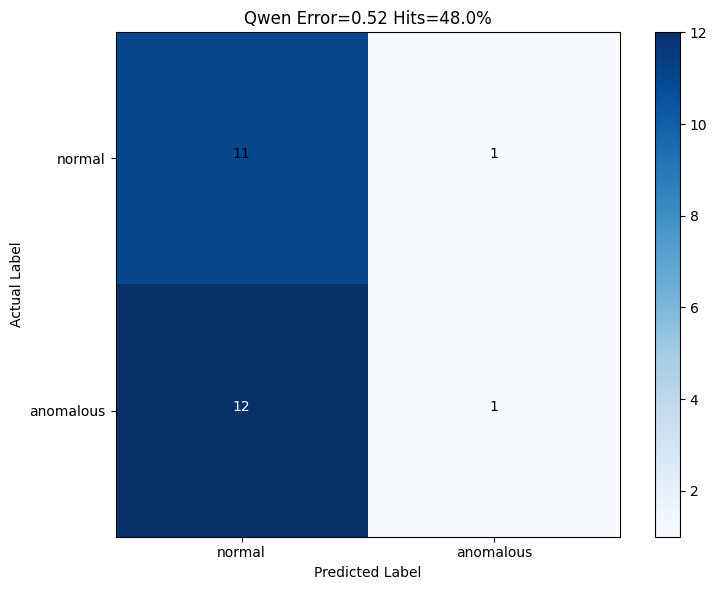

In [49]:
# The function for testing deepseek via hyperbolic

Tester.test(deepseek_via_hyperbolic, test)